# ........................................The Spark Foundation..................................................


## ..........................Data Science and Business Analytics Internship......................................

## ................Stock Market Prediction using Numerical and Textual Analysis........................

### .................................................................................................................................................................. Brijesh Kumar

## Importing Libraries

In [ ]:
!pip install textblob
!pip install vaderSentiment
!pip install statsmodels

In [105]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from pandas_datareader import data as pdr
import yfinance as yf

import statsmodels.api as sms
from statsmodels.tsa.stattools import adfuller

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob

from math import sqrt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

 ## Defining Helping functions

In [ ]:
#function to get subjectivity of news headlines
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

#function to get polarity of news headlines
def getPolarity(text):
    return TextBlob(text).sentiment.polarity

#function to get sentiment scores of news headlines
def getSIA(text):
    sia = SentimentIntensityAnalyzer()
    sentiment = sia.polarity_scores(text)
    return sentiment

## Downloading Data

 Download stock price data

In [5]:
yf.pdr_override()
stock_data = pdr.get_data_yahoo('^BESN', start = '2001-01-01', end = '2022-03-31')

# stock_data.to_excel('stock_price.xlsx')  #storing data locally

Download News headline data

In [6]:
news_data = pd.read_csv('india-news-headlines.csv')

## Exploring stock_price data

In [7]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5234 entries, 0 to 5233
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       5234 non-null   datetime64[ns]
 1   Open       5234 non-null   float64       
 2   High       5234 non-null   float64       
 3   Low        5234 non-null   float64       
 4   Close      5234 non-null   float64       
 5   Adj Close  5234 non-null   float64       
 6   Volume     5234 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 286.4 KB


In [15]:
stock_data=stock_data.set_index('Date')

In [107]:
stock_data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2001-01-02,3953.219971,4028.570068,3929.370117,4018.879883,4018.879883,0
2001-01-03,3977.580078,4067.659912,3977.580078,4060.020020,4060.020020,0
2001-01-04,4180.970215,4180.970215,4109.549805,4115.370117,4115.370117,0
2001-01-05,4116.339844,4195.009766,4115.350098,4183.729980,4183.729980,0
2001-01-08,4164.759766,4206.720215,4101.529785,4120.430176,4120.430176,0


In [108]:
stock_data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-03-24,57190.050781,57827.988281,57138.511719,57595.679688,57595.679688,51400
2022-03-25,57801.718750,57845.371094,57100.238281,57362.199219,57362.199219,6900
2022-03-28,57472.718750,57638.339844,56825.089844,57593.488281,57593.488281,6300
2022-03-29,57814.761719,58001.531250,57639.351562,57943.648438,57943.648438,12100
2022-03-30,58362.851562,58727.781250,58176.000000,58683.988281,58683.988281,6300


<AxesSubplot: xlabel='Date'>

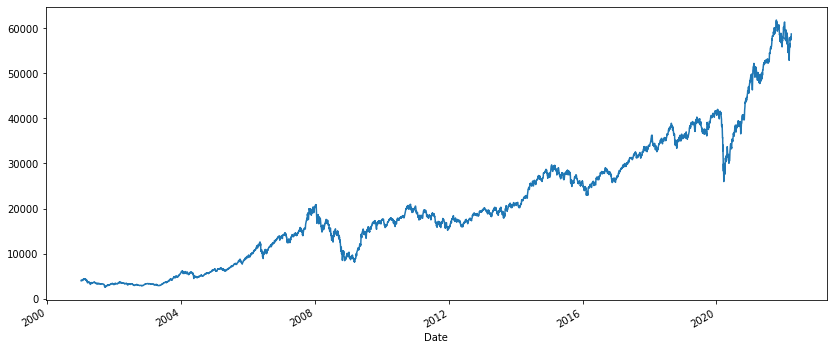

In [18]:
stock_data.Close.plot(figsize = (14,6))

 check whether data is stationary or not

In [19]:
result=adfuller(stock_data.Close)
print('ADF Statistics: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
if(result[1]<=0.05):
    print('strong evidence against the null hypothesis , reject the null hypothesis. Data has no unit root and is stationary.')
else:
    print('Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary.')

ADF Statistics: 1.0860486966351672
p-value: 0.995095777362035
Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary.


create extra features for prediction

In [21]:
stock_data['5_dayRolling']=stock_data.Close.rolling(window=5,min_periods=1).mean()
stock_data['20_dayRolling']=stock_data.Close.rolling(window=20,min_periods=1).mean()
stock_data['65_dayRolling']=stock_data.Close.rolling(window=65,min_periods=1).mean()
stock_data["month"] = stock_data.index.month
stock_data["day"] = stock_data.index.day
stock_data["dayofweek"] = stock_data.index.dayofweek
stock_data["week"] = stock_data.index.week
stock_data.head()

<ipython-input-21-1c7ce16ed949>:7: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  stock_data["week"] = stock_data.index.week


,Open,High,Low,Close,Adj Close,Volume,5_dayRolling,20_dayRolling,65_dayRolling,month,day,dayofweek,week
Date,,,,,,,,,,,,,
2001-01-02,3953.219971,4028.570068,3929.370117,4018.879883,4018.879883,0,4018.879883,4018.879883,4018.879883,1,2,1,1
2001-01-03,3977.580078,4067.659912,3977.580078,4060.020020,4060.020020,0,4039.449951,4039.449951,4039.449951,1,3,2,1
2001-01-04,4180.970215,4180.970215,4109.549805,4115.370117,4115.370117,0,4064.756673,4064.756673,4064.756673,1,4,3,1
2001-01-05,4116.339844,4195.009766,4115.350098,4183.729980,4183.729980,0,4094.500000,4094.500000,4094.500000,1,5,4,1
2001-01-08,4164.759766,4206.720215,4101.529785,4120.430176,4120.430176,0,4099.686035,4099.686035,4099.686035,1,8,0,2


## Exploring news headlines data

In [22]:
news_data.head()

,publish_date,headline_category,headline_text
0,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
1,20010102,unknown,Fissures in Hurriyat over Pak visit
2,20010102,unknown,America's unwanted heading for India?
3,20010102,unknown,For bigwigs; it is destination Goa
4,20010102,unknown,Extra buses to clear tourist traffic


In [24]:
news_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650970 entries, 0 to 3650969
Data columns (total 3 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   publish_date       int64 
 1   headline_category  object
 2   headline_text      object
dtypes: int64(1), object(2)
memory usage: 83.6+ MB


check for duplicate rows

In [26]:
news_data[news_data.duplicated()]

,publish_date,headline_category,headline_text
20,20010102,unknown,America's unwanted heading for India?
26,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
27,20010102,unknown,Fissures in Hurriyat over Pak visit
28,20010102,unknown,America's unwanted heading for India?
29,20010102,unknown,For bigwigs; it is destination Goa
...,...,...,...
3644803,20220319,city.chennai,More Chennai women take buses for free ride
3644810,20220319,city.goa,Ukrainians; Russians skip Holi celebrations in...
3646409,20220322,city.hubballi,BJP divided over probable induction of Basavar...
3648598,20220327,city.chennai,Father; daughter killed in TN as e-bike on cha...


In [27]:
news_data = news_data.drop_duplicates(inplace = False, keep = 'first')

In [29]:
len(news_data)

3626110

merge all the news headlines belong to particular day into single string

In [30]:
unique = news_data.publish_date.unique()
join = []
for item in unique[:]:
    join.append(' '.join(str.lower() for str in news_data[news_data.publish_date==item].headline_text.iloc[:]))
    num = len(text_data[text_data.publish_date==item])

create new dataset with merged news headlines

In [33]:
merged_healines = pd.Dataframe(data=join,index=unique,columns=['headlines'])
merged_headlines['Date'] = pd.to_datetime(merged_headlines.index,format = '%Y%m%d')
merged_headlines=merged_headlines.to_datetime('Date')
merged_headlines.head()

,headlines
Date,
2001-01-02,status quo will not be disturbed at ayodhya; s...
2001-01-03,powerless north india gropes in the dark think...
2001-01-04,the string that pulled stephen hawking to indi...
2001-01-05,light combat craft takes india into club class...
2001-01-06,light combat craft takes india into club class...


In [35]:
#check for null values
len(merged_headlines[merged_headlines.headlines.isnull()==True])

0

In [ ]:
merged_headlines['Subjectivity'] = merged_headlines.headlines.apply(getSubjectivity)
merged_headlines['Polarity'] = merged_headlines.headlines.apply(getPolarity)

In [ ]:
compound,neg,neu,pos = [],[],[],[]
SIA = 0

for i in range (0, len(df)):
    SIA = getSIA(merged_headlines.headlines[i])
    print(i)
    compound.append(SIA['compound'])
    neg.append(SIA['neg'])
    neu.append(SIA['neu'])
    pos.append(SIA['pos'])

In [ ]:
merged_headlines['compound'] = compound
merged_headlines['negative'] = neg
merged_headlines['positive'] = pos
merged_headlines['neutral'] = neu

In [45]:
merged_headlines.head()

,headlines,Subjectivity,Polarity,compound,negative,positive,neutral
Date,,,,,,,
2001-01-02,status quo will not be disturbed at ayodhya; s...,0.293056,0.193519,-0.9678,0.128,0.076,0.796
2001-01-03,powerless north india gropes in the dark think...,0.407692,0.088462,0.5940,0.117,0.123,0.761
2001-01-04,the string that pulled stephen hawking to indi...,0.481895,0.088034,0.9425,0.096,0.112,0.792
2001-01-05,light combat craft takes india into club class...,0.465542,0.257415,0.9559,0.110,0.159,0.731
2001-01-06,light combat craft takes india into club class...,0.464935,0.219481,-0.5574,0.165,0.133,0.702


## Merge stock price data and news headlines data

In [47]:
merged_data = pd.merge(stock_data,merged_headlines,how='inner',on='Date')
merged_data.head()

,Open,High,Low,Close,Adj Close,Volume,5_dayRolling,20_dayRolling,65_dayRolling,month,day,dayofweek,week,headlines,Subjectivity,Polarity,compound,negative,positive,neutral
Date,,,,,,,,,,,,,,,,,,,,
2001-01-02,3953.219971,4028.570068,3929.370117,4018.879883,4018.879883,0,4018.879883,4018.879883,4018.879883,1,2,1,1,status quo will not be disturbed at ayodhya; s...,0.293056,0.193519,-0.9678,0.128,0.076,0.796
2001-01-03,3977.580078,4067.659912,3977.580078,4060.020020,4060.020020,0,4039.449951,4039.449951,4039.449951,1,3,2,1,powerless north india gropes in the dark think...,0.407692,0.088462,0.5940,0.117,0.123,0.761
2001-01-04,4180.970215,4180.970215,4109.549805,4115.370117,4115.370117,0,4064.756673,4064.756673,4064.756673,1,4,3,1,the string that pulled stephen hawking to indi...,0.481895,0.088034,0.9425,0.096,0.112,0.792
2001-01-05,4116.339844,4195.009766,4115.350098,4183.729980,4183.729980,0,4094.500000,4094.500000,4094.500000,1,5,4,1,light combat craft takes india into club class...,0.465542,0.257415,0.9559,0.110,0.159,0.731
2001-01-08,4164.759766,4206.720215,4101.529785,4120.430176,4120.430176,0,4099.686035,4099.686035,4099.686035,1,8,0,2,sangh parivar; babri panel up the ante frontru...,0.436176,0.016234,-0.7506,0.114,0.092,0.794


## Train Model for Prediction

In [55]:
X = merged_data.drop(['headlines','Close'],axis=1)
y = merged_data.Close

In [71]:
X_train,X_test,y_train,y_test = X[:-60],X[-60:],y[:-60],y[-60:]
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((5145, 18), (5145,), (60, 18), (60,))

In [72]:
rfg = RandomForestRegressor(n_estimators = 500, criterion='mse')
rfg.fit(X_train,y_train)

RandomForestRegressor(n_estimators=500)

In [90]:
rf_pred = rfg.predict(X_test)

c = []
for i in range(len(rf_pred)):
    c.append([y_test.values[i], rf_pred[i]])

result = pd.DataFrame(data =c,columns = ['Actual Close Price','Predicted Close Price'],index = X_test.index)

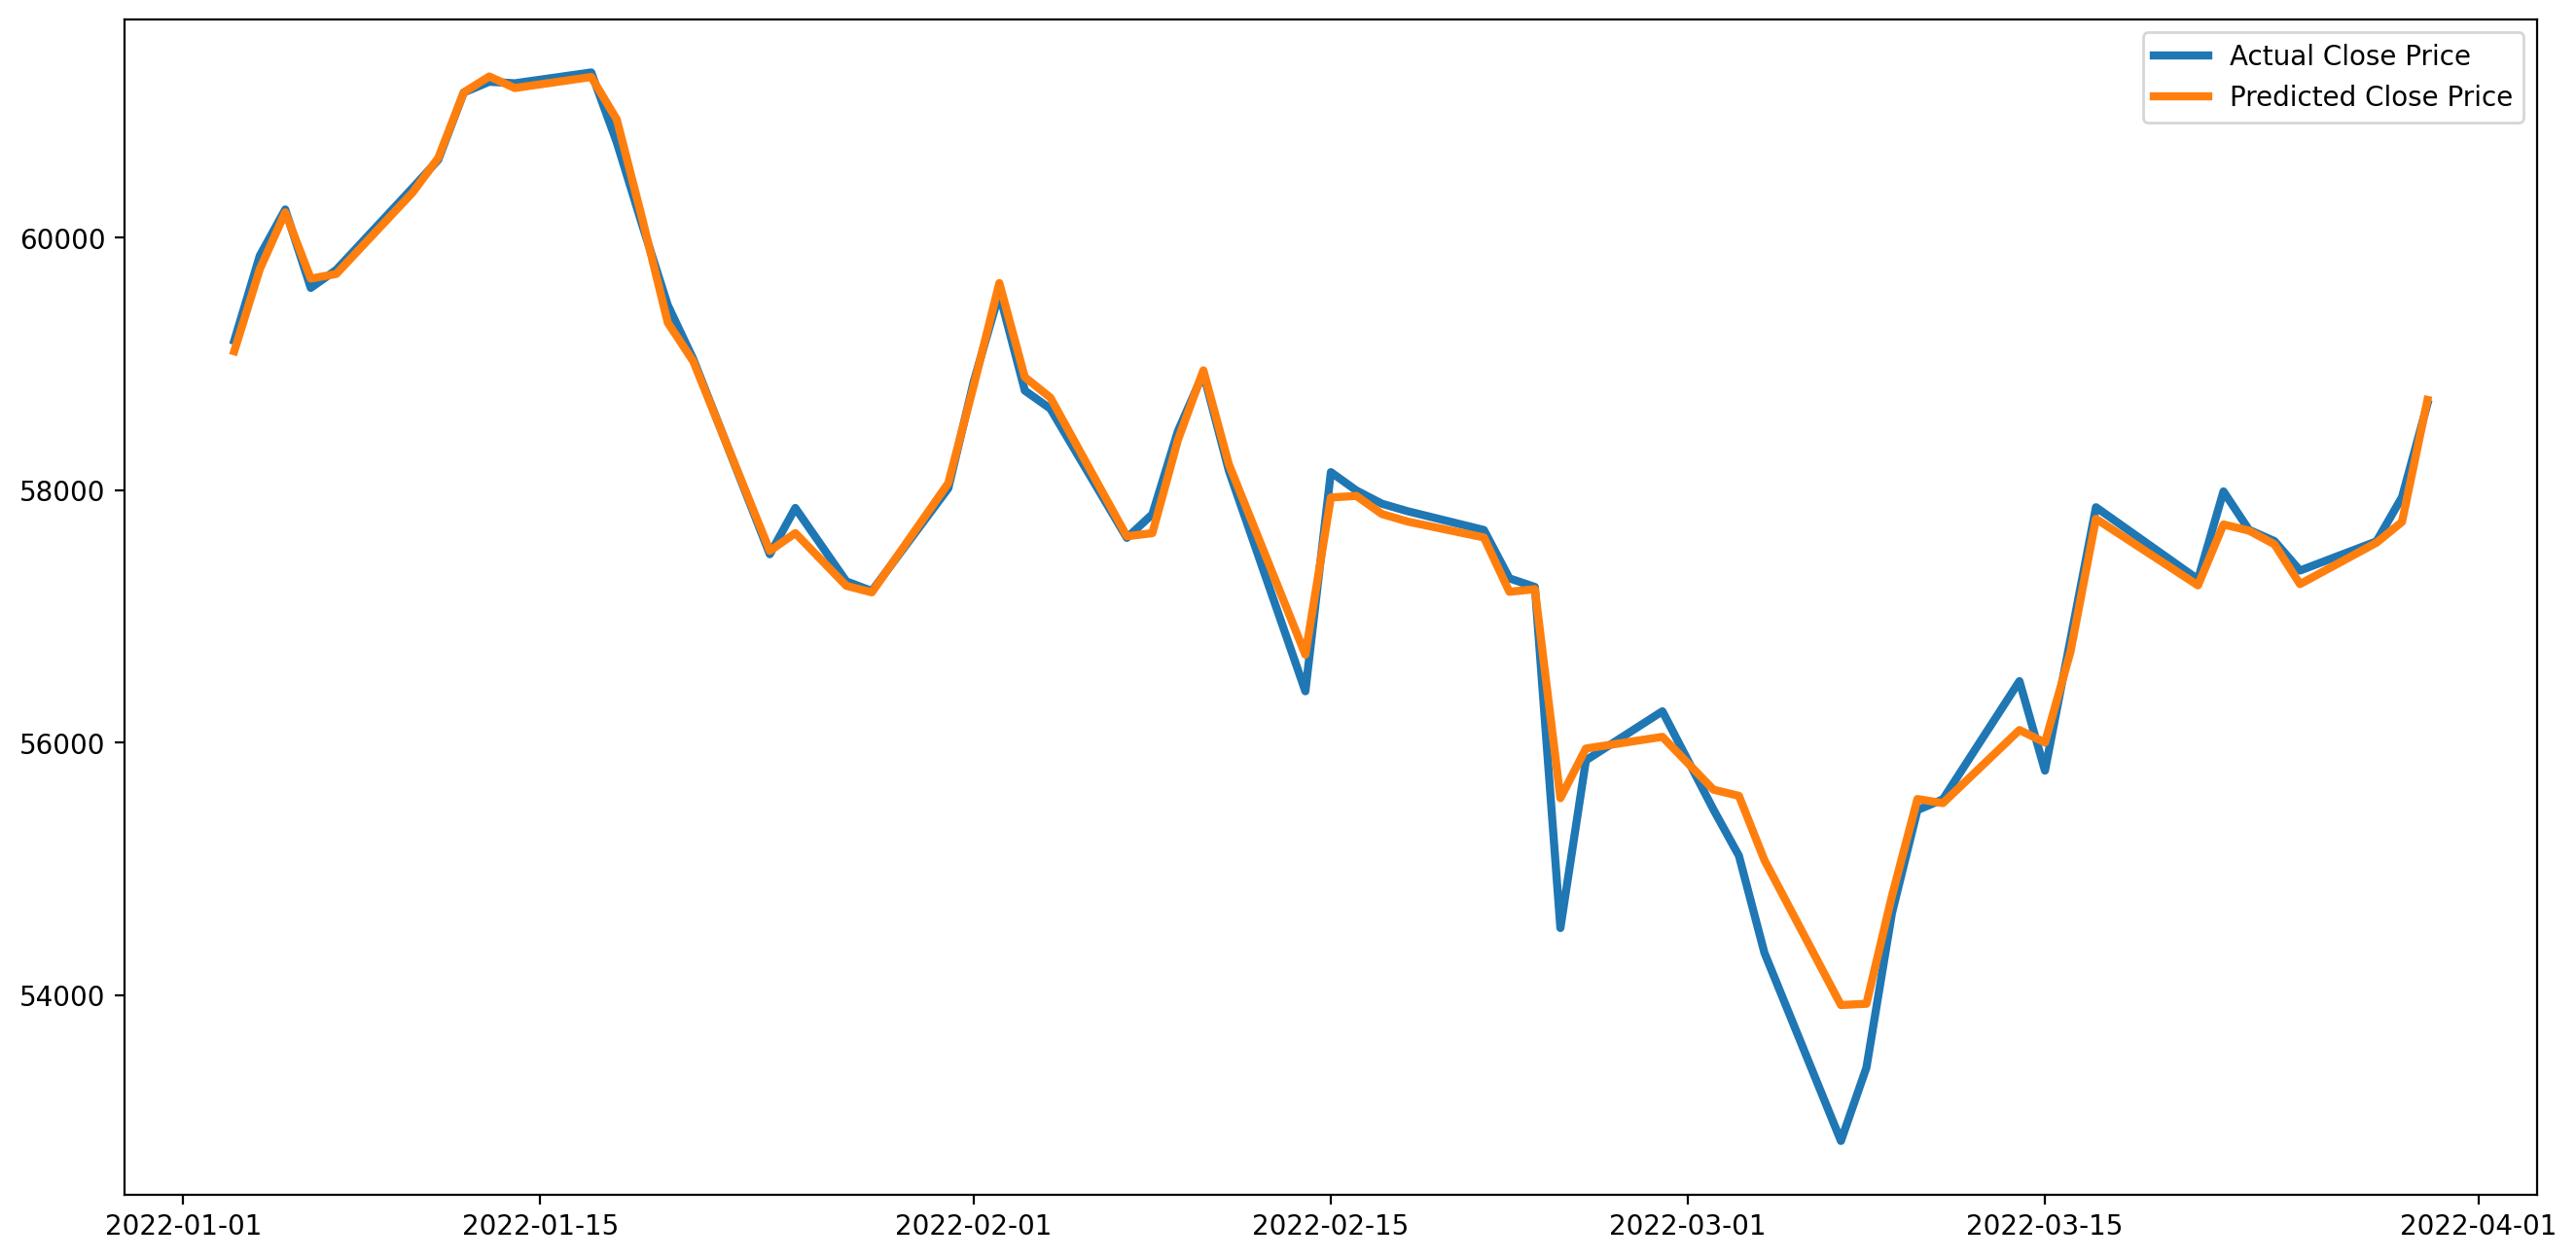

In [103]:
plt.rcParams['figure.figsize']=(16,8)
plt.rcParams['figure.dpi']=200
plt.plot(result['Actual Close Price'],label='Actual Close Price',lw =3)
plt.plot(result['Predicted Close Price'],label='Predicted Close Price',lw =3)
plt.legend(loc='upper right')

In [104]:
rmse_rf = sqrt(mean_squared_error(rf_pred,y_test.values))
print('RF rmse : ',rmse_rf)

RF rmse :  258.89287203261796
